<a href="https://colab.research.google.com/github/iamshahidkamal/final-assignment/blob/main/custom_cnn_2000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # Choose the kaggle.json file

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"iamshahidkamal","key":"bd26cd294b18b1f886d17cc036a6feb0"}'}

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Search for the dataset on Kaggle (replace with your dataset name)
!kaggle datasets download karoladel/isic-2019
# Unzip the downloaded dataset
!unzip isic-2018.zip -d /content/dataset/

Dataset URL: https://www.kaggle.com/datasets/karoladel/isic-2019
License(s): unknown
100% 9.09G/9.10G [02:19<00:00, 96.5MB/s]
100% 9.10G/9.10G [02:19<00:00, 70.0MB/s]
unzip:  cannot find or open isic-2018.zip, isic-2018.zip.zip or isic-2018.zip.ZIP.


In [ ]:
!unzip isic-2019 -d /content/dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/ISIC - 2019/train/Melanoma/ISIC_0053909.jpg  
  inflating: /content/dataset/ISIC - 2019/train/Melanoma/ISIC_0053916.jpg  
  inflating: /content/dataset/ISIC - 2019/train/Melanoma/ISIC_0053933.jpg  
  inflating: /content/dataset/ISIC - 2019/train/Melanoma/ISIC_0053945.jpg  
  inflating: /content/dataset/ISIC - 2019/train/Melanoma/ISIC_0053947.jpg  
  inflating: /content/dataset/ISIC - 2019/train/Melanoma/ISIC_0053953.jpg  
  inflating: /content/dataset/ISIC - 2019/train/Melanoma/ISIC_0053960.jpg  
  inflating: /content/dataset/ISIC - 2019/train/Melanoma/ISIC_0053971.jpg  
  inflating: /content/dataset/ISIC - 2019/train/Melanoma/ISIC_0053973.jpg  
  inflating: /content/dataset/ISIC - 2019/train/Melanoma/ISIC_0053985.jpg  
  inflating: /content/dataset/ISIC - 2019/train/Melanoma/ISIC_0054006.jpg  
  inflating: /content/dataset/ISIC - 2019/train/Melanoma/ISIC_0054021.jpg  
  inflating: /content/dataset/ISIC - 

In [ ]:
# Check the files
!ls /content/dataset/

'ISIC - 2019'


In [ ]:
import os

# Check the train directory structure
train_dir = '/content/dataset/ISIC - 2019/train'  # Update with your actual dataset path
print(os.listdir(train_dir))

['Squamous cell carcinoma', 'Benign keratosis', 'Actinic keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Basal cell carcinoma', 'Melanoma', 'Vascular lesion']


In [ ]:
import os
import shutil
import random

# Define source paths
train_dir = '/content/dataset/ISIC - 2019/train'
val_dir = '/content/dataset/ISIC - 2019/val'
test_dir = '/content/dataset/ISIC - 2019/test'

# Define target paths
filtered_train_dir = '/content/filtered_dataset/train'
filtered_val_dir = '/content/filtered_dataset/val'
filtered_test_dir = '/content/filtered_dataset/test'

# Classes to include
classes_to_keep = ['Melanoma', 'Melanocytic nevus']

# Create directories for filtered data
for subset in ['train', 'val', 'test']:
    for cls in classes_to_keep:
        os.makedirs(f'/content/filtered_dataset/{subset}/{cls}', exist_ok=True)

# Function to copy and limit images
def filter_and_copy_images(source_dir, target_dir, classes, max_images=2000):
    for cls in classes:
        source_path = os.path.join(source_dir, cls)
        target_path = os.path.join(target_dir, cls)

        # Get all images in the class folder
        images = os.listdir(source_path)
        random.shuffle(images)  # Shuffle to randomly pick images

        # Copy up to max_images
        for img in images[:max_images]:
            shutil.copy(os.path.join(source_path, img), os.path.join(target_path, img))

# Apply filtering
filter_and_copy_images(train_dir, filtered_train_dir, classes_to_keep)
filter_and_copy_images(val_dir, filtered_val_dir, classes_to_keep, max_images=500)  # Use fewer validation images
filter_and_copy_images(test_dir, filtered_test_dir, classes_to_keep)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Train generator
train_generator = datagen.flow_from_directory(
    '/content/filtered_dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # Binary classification
)

# Validation generator
val_generator = datagen.flow_from_directory(
    '/content/filtered_dataset/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 4000 images belonging to 2 classes.
Found 850 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential([
    # Convolutional layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    # Convolutional layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Convolutional layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the output
    Flatten(),

    # Fully connected layer
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout for regularization

    # Output layer (1 neuron for binary classification)
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Adjust based on time
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 575s 5s/step - accuracy: 0.5441 - loss: 0.8178 - val_accuracy: 0.5841 - val_loss: 0.6709
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6111 - val_loss: 0.5920
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 573s 5s/step - accuracy: 0.6435 - loss: 0.6465 - val_accuracy: 0.6623 - val_loss: 0.6184
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6667 - val_loss: 0.6443
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 565s 4s/step - accuracy: 0.6549 - loss: 0.6266 - val_accuracy: 0.6623 - val_loss: 0.5908
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7778 - val_loss: 0.5370
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 554s 4s/step - accuracy: 0.6528 - loss: 0.6123 - val_accuracy: 0.6587 - val_loss: 0.5751
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6111 - val_loss: 0.6543
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 574s 4s/step - accuracy: 0.6783 - loss: 

In [ ]:
# Test generator
test_generator = datagen.flow_from_directory(
    '/content/filtered_dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Found 1325 images belonging to 2 classes.
42/42 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7135 - loss: 0.5425
Test Loss: 0.5446310043334961
Test Accuracy: 0.7139622569084167


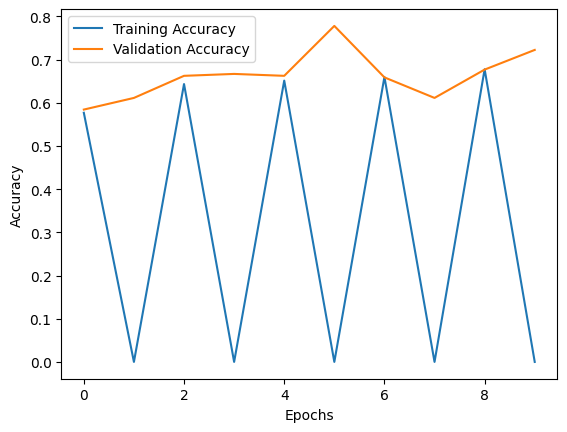

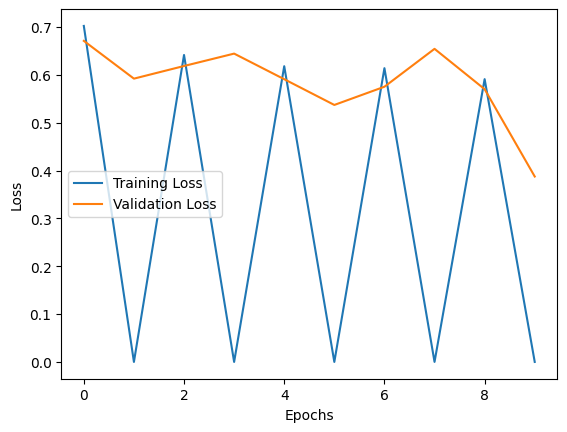

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np

# Predict probabilities on the test set
y_pred_probs = model.predict(test_generator)

# Convert probabilities to binary class labels (threshold = 0.5)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Get true labels
y_true = test_generator.classes

42/42 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step


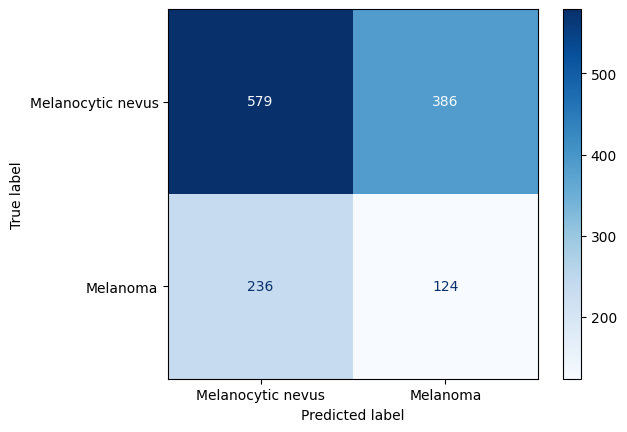

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap='Blues')

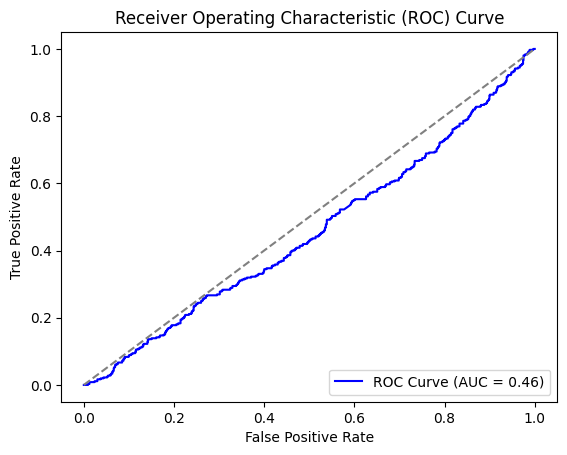

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Compute the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

# Compute the AUC score
auc_score = roc_auc_score(y_true, y_pred_probs)
print(f"AUC Score: {auc_score:.2f}")

AUC Score: 0.46


In [ ]:
model.save('/content/melanoma_nevus_model.h5')

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, validation_data=val_generator, epochs=5)  # Adjust epochs

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 971s 8s/step - accuracy: 0.5150 - loss: 0.7471 - val_accuracy: 0.5941 - val_loss: 0.6717
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 947s 8s/step - accuracy: 0.5187 - loss: 0.6968 - val_accuracy: 0.4624 - val_loss: 0.6923
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 935s 7s/step - accuracy: 0.5067 - loss: 0.6928 - val_accuracy: 0.4118 - val_loss: 0.6953
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1028s 8s/step - accuracy: 0.5172 - loss: 0.6918 - val_accuracy: 0.4118 - val_loss: 0.6930
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 981s 8s/step - accuracy: 0.5076 - loss: 0.6923 - val_accuracy: 0.4118 - val_loss: 0.6973


In [ ]:
def filter_and_copy_images(source_dir, target_dir, classes):
    for cls in classes:
        source_path = os.path.join(source_dir, cls)
        target_path = os.path.join(target_dir, cls)

        # Check if the source folder exists
        if not os.path.exists(source_path):
            print(f"Warning: {source_path} does not exist. Skipping...")
            continue

        os.makedirs(target_path, exist_ok=True)

        # Get all images in the class folder
        images = os.listdir(source_path)

        # Copy all images
        for img in images:
            shutil.copy(os.path.join(source_path, img), os.path.join(target_path, img))

In [ ]:
filter_and_copy_images(train_dir, filtered_train_dir, classes_to_keep)
filter_and_copy_images(val_dir, filtered_val_dir, classes_to_keep)
filter_and_copy_images(test_dir, filtered_test_dir, classes_to_keep)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Updated filtered dataset paths
filtered_train_dir = '/content/filtered_dataset/train'
filtered_val_dir = '/content/filtered_dataset/val'

# Data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Train generator: Load all training images
train_generator = datagen.flow_from_directory(
    filtered_train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Validation generator: Load all validation images
val_generator = datagen.flow_from_directory(
    filtered_val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 14791 images belonging to 2 classes.
Found 1281 images belonging to 2 classes.


In [ ]:
# Train the model for more epochs
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  # Increased from 10 to 15
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 30/462 ━━━━━━━━━━━━━━━━━━━━ 43:50 6s/step - accuracy: 0.6314 - loss: 0.6954

KeyboardInterrupt: 

In [ ]:
# Test generator: Load all test images
test_generator = datagen.flow_from_directory(
    '/content/filtered_dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")